# Predicting Remaining Useful Life (advanced)
<p style="margin:30px">
    <img style="display:inline; margin-right:50px" width=50% src="https://www.featuretools.com/wp-content/uploads/2017/12/FeatureLabs-Logo-Tangerine-800.png" alt="Featuretools" />
    <img style="display:inline" width=15% src="https://upload.wikimedia.org/wikipedia/commons/e/e5/NASA_logo.svg" alt="NASA" />
</p>

This notebook has a more advanced workflow than [the other notebook](Simple%20Featuretools%20RUL%20Demo.ipynb) for predicting Remaining Useful Life (RUL). If you are a new to either this dataset or Featuretools, I would recommend reading the other notebook first.

## Highlights
* Demonstrate how novel entityset structures improve predictive accuracy
* Use TSFresh Primitives from a featuretools [addon](https://docs.featuretools.com/getting_started/install.html#add-ons)
* Improve Mean Absolute Error by tuning hyper parameters with [BTB](https://github.com/HDI-Project/BTB)

Here is a collection of mean absolute errors from both notebooks. Though we've used averages where possible (denoted by \*), the randomness in the Random Forest Regressor and how we choose labels from the train data changes the score.

|                                 | Train/Validation MAE|  Test MAE|
|---------------------------------|---------------------|----------|
| Median Baseline                 | 72.06*              | 50.66*   |
| Simple Featuretools             | 40.92*              | 39.56    |
| Advanced: Custom Primitives     | 35.90*              | 28.84    |
| Advanced: Hyperparameter Tuning | 34.80*              | 27.85    |


# Step 1: Load Data
We load in the train data using the same function we used in the previous notebook:

In [1]:
import composeml as cp
import numpy as np
import pandas as pd
import featuretools as ft
import utils
import os

from tqdm import tqdm
from sklearn.cluster import KMeans

In [2]:
data_path = 'data/train_FD004.txt'
data = utils.load_data(data_path)
data.head()

Loaded data with:
61249 Recordings
249 Engines
21 Sensor Measurements
3 Operational Settings


,engine_no,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,index,time
index,,,,,,,,,,,,,,,,,,,,,
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,0,2000-01-01 00:00:00
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,1,2000-01-01 00:10:00
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,2,2000-01-01 00:20:00
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,3,2000-01-01 00:30:00
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,4,2000-01-01 00:40:00


We also make cutoff times by using [Compose](https://compose.featurelabs.com) for generating labels on engines that reach at least 100 cycles. For each engine, we generate 10 labels that are spaced 10 cycles apart.

In [3]:
def remaining_useful_life(df):
    return len(df) - 1

lm = cp.LabelMaker(
    target_entity='engine_no',
    time_index='time',
    labeling_function=remaining_useful_life,
)

label_times = lm.search(
    data.sort_values('time'),
    num_examples_per_instance=10,
    minimum_data=100,
    gap=10,
    verbose=True,
)

label_times.head()

Elapsed: 00:01 | Remaining: 00:00 | Progress: 100%|█████████████████████████████████████████████| engine_no: 2490/2490 


,engine_no,time,remaining_useful_life
0,1,2000-01-01 16:40:00,220
1,1,2000-01-01 18:20:00,210
2,1,2000-01-01 20:00:00,200
3,1,2000-01-01 21:40:00,190
4,1,2000-01-01 23:20:00,180


We're going to make 5 sets of cutoff times to use for cross validation by random sampling the labels times we created previously.

In [4]:
splits = 5
cutoff_time_list = []

for i in range(splits):
    sample = label_times.sample(n=249, random_state=i)
    sample.sort_index(inplace=True)
    cutoff_time_list.append(sample)

cutoff_time_list[0].head()

,engine_no,time,remaining_useful_life
1,1,2000-01-01 18:20:00,210
9,1,2000-01-02 07:40:00,130
10,2,2000-01-03 22:10:00,198
14,2,2000-01-04 04:50:00,158
27,3,2000-01-06 11:40:00,136


We're going to do something fancy for our entityset. The values for `operational_setting` 1-3 are continuous but create an implicit relation between different engines. If two engines have a similar `operational_setting`, it could indicate that we should expect the sensor measurements to mean similar things. We make clusters of those settings using [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) from scikit-learn and make a new entity from the clusters.

In [5]:
nclusters = 50

def make_entityset(data, nclusters, kmeans=None):
    X = data[[
        'operational_setting_1',
        'operational_setting_2',
        'operational_setting_3',
    ]]

    if kmeans is None:
        kmeans = KMeans(n_clusters=nclusters).fit(X)

    data['settings_clusters'] = kmeans.predict(X)

    es = ft.EntitySet('Dataset')

    es.entity_from_dataframe(
        dataframe=data,
        entity_id='recordings',
        index='index',
        time_index='time',
    )

    es.normalize_entity(
        base_entity_id='recordings',
        new_entity_id='engines',
        index='engine_no',
    )

    es.normalize_entity(
        base_entity_id='recordings',
        new_entity_id='settings_clusters',
        index='settings_clusters',
    )

    return es, kmeans


es, kmeans = make_entityset(data, nclusters)
es

Entityset: Dataset
  Entities:
    recordings [Rows: 61249, Columns: 29]
    engines [Rows: 249, Columns: 2]
    settings_clusters [Rows: 50, Columns: 2]
  Relationships:
    recordings.engine_no -> engines.engine_no
    recordings.settings_clusters -> settings_clusters.settings_clusters

## Visualize EntitySet

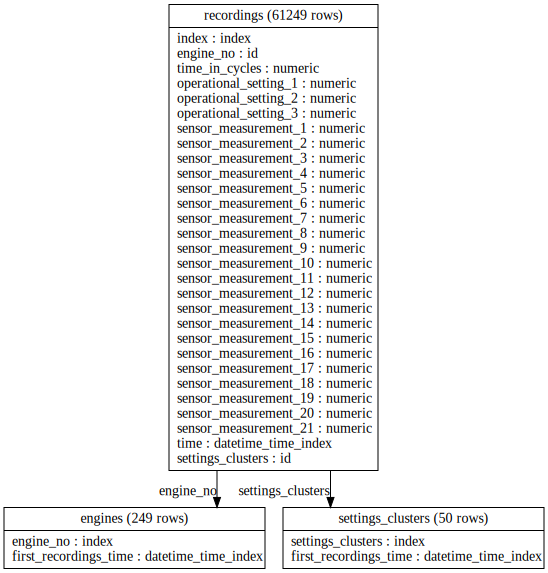

In [6]:
es.plot()

# Step 2: DFS and Creating a Model
In addition to changing our `EntitySet` structure, we're also going to use the [Complexity](http://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html#tsfresh.feature_extraction.feature_calculators.cid_ce) time series primitive from the featuretools [addon](https://docs.featuretools.com/getting_started/install.html#add-ons) of ready-to-use TSFresh Primitives.

Just like in the previous notebook, we will be using [EvalML](https://evalml.alteryx.com/en/stable/)

<p align="center">
<img width=50% src="https://evalml-web-images.s3.amazonaws.com/evalml_horizontal.svg" alt="Featuretools" />
</p>


In [7]:
from featuretools.tsfresh import CidCe

fm, features = ft.dfs(
    entityset=es,
    target_entity='engines',
    agg_primitives=['last', 'max', CidCe(normalize=False)],
    trans_primitives=[],
    chunk_size=.26,
    cutoff_time=cutoff_time_list[0],
    max_depth=3,
    verbose=True,
)

fm.to_csv('advanced_fm.csv')
fm.head()

Built 304 features
Elapsed: 02:03 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


,"CID_CE(recordings.operational_setting_1, normalize=False)","CID_CE(recordings.operational_setting_2, normalize=False)","CID_CE(recordings.operational_setting_3, normalize=False)","CID_CE(recordings.sensor_measurement_1, normalize=False)","CID_CE(recordings.sensor_measurement_10, normalize=False)","CID_CE(recordings.sensor_measurement_11, normalize=False)","CID_CE(recordings.sensor_measurement_12, normalize=False)","CID_CE(recordings.sensor_measurement_13, normalize=False)","CID_CE(recordings.sensor_measurement_14, normalize=False)","CID_CE(recordings.sensor_measurement_15, normalize=False)",...,MAX(recordings.settings_clusters.MAX(recordings.sensor_measurement_21)),MAX(recordings.settings_clusters.MAX(recordings.sensor_measurement_3)),MAX(recordings.settings_clusters.MAX(recordings.sensor_measurement_4)),MAX(recordings.settings_clusters.MAX(recordings.sensor_measurement_5)),MAX(recordings.settings_clusters.MAX(recordings.sensor_measurement_6)),MAX(recordings.settings_clusters.MAX(recordings.sensor_measurement_7)),MAX(recordings.settings_clusters.MAX(recordings.sensor_measurement_8)),MAX(recordings.settings_clusters.MAX(recordings.sensor_measurement_9)),MAX(recordings.settings_clusters.MAX(recordings.time_in_cycles)),remaining_useful_life
engine_no,,,,,,,,,,,,,,,,,,,,,
1,208.777576,4.355841,211.660105,380.627959,1.792150,46.543688,1939.238240,1903.468066,1188.077642,10.661766,...,23.4578,1585.87,1404.99,14.62,21.59,553.15,2387.96,9053.86,111,210
1,269.413940,5.621277,282.842712,487.954763,2.392969,61.084289,2503.466467,2543.782289,1626.735462,14.498524,...,23.5729,1588.39,1404.99,14.62,21.59,554.23,2388.01,9055.13,191,130
2,199.764962,4.194227,195.959179,353.967679,1.737872,43.901649,1862.523931,1762.763195,1164.156379,10.303977,...,23.8649,1603.28,1422.53,14.62,21.61,567.07,2388.50,9114.84,320,198
2,230.523809,4.792752,240.000000,410.530161,2.001300,52.038703,2141.370941,2158.928528,1394.027359,12.292916,...,23.8649,1603.28,1422.53,14.62,21.61,567.07,2388.50,9114.84,321,158
3,271.826093,5.854931,293.938769,472.270085,2.475318,64.716036,2576.388154,2643.922171,1737.037013,15.251866,...,23.8649,1603.28,1434.23,14.62,21.61,567.07,2388.50,9114.84,321,136


We build 4 more feature matrices with the same feature set but different cutoff times. That lets us test the pipeline multiple times before using it on test data.

In [8]:
fm_list = [fm]

for i in tqdm(range(1, splits)):
    es = make_entityset(data, nclusters, kmeans=kmeans)[0]
    fm = ft.calculate_feature_matrix(
        entityset=es,
        features=features,
        chunk_size=.26,
        cutoff_time=cutoff_time_list[i],
    )
    fm_list.append(fm)

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [08:14<00:00, 123.54s/it]


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import evalml
from evalml import AutoMLSearch

In [11]:
def pipeline_for_test(fm_list, hyperparams=None, do_selection=False):
    scores = []
    regs = []
    selectors = []

    hyperparams = hyperparams or {
        'n_estimators': 100,
        'max_feats': 50,
        'nfeats': 50,
    }

    for fm in fm_list:
        X = fm.copy().fillna(0)
        y = X.pop('remaining_useful_life')

        n_estimators = int(hyperparams['n_estimators'])
        max_features = int(hyperparams['max_feats'])
        max_features = min(max_features, int(hyperparams['nfeats']))

        X_train, X_test, y_train, y_test = train_test_split(X, y)
        
        automl = AutoMLSearch(problem_type="regression", objective="mae", max_batches=3, max_iterations=20)
        automl.search(X_train, y_train, data_checks='disabled')


        pipeline = automl.best_pipeline
        pipeline.fit(X_train, y_train)

        preds = pipeline.predict(X_test)
        mae = mean_absolute_error(preds, y_test)
        scores.append(mae)

    return scores, pipeline, selectors


scores, pipeline, selectors = pipeline_for_test(fm_list)
print([float('{:.1f}'.format(score)) for score in scores])

mean, std = np.mean(scores), np.std(scores)
info = 'Average MAE: {:.1f}, Std: {:.2f}\n'
print(info.format(mean, std))

print(pipeline.feature_importance[0:10])

`X` passed was not a DataTable. EvalML will try to convert the input as a Woodwork DataTable and types will be inferred. To control this behavior, please pass in a Woodwork DataTable instead.
`y` passed was not a DataColumn. EvalML will try to convert the input as a Woodwork DataTable and types will be inferred. To control this behavior, please pass in a Woodwork DataTable instead.
Generating pipelines to search over...
*****************************
* Beginning pipeline search *
*****************************

Optimizing for MAE. 
Lower score is better.

Searching up to 3 batches for a total of 20 pipelines. 
Allowed model families: xgboost, linear_model, catboost, random_forest, decision_tree, extra_trees



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

Batch 1: (1/20) Mean Baseline Regression Pipeline        Elapsed:00:00
	Starting cross validation
	Finished cross validation - mean MAE: 64.689
Batch 1: (2/20) Decision Tree Regressor. w/ Imputer      Elapsed:00:00
	Starting cross validation
	Finished cross validation - mean MAE: 61.696
Batch 1: (3/20) Extra Trees Regressor w/ Imputer         Elapsed:00:02
	Starting cross validation
	Finished cross validation - mean MAE: 40.548
Batch 1: (4/20) XGBoost Regressor w/ Imputer             Elapsed:00:04
	Starting cross validation
	Finished cross validation - mean MAE: 39.148
Batch 1: (5/20) CatBoost Regressor w/ Imputer            Elapsed:00:08
	Starting cross validation
	Finished cross validation - mean MAE: 59.578
Batch 1: (6/20) Random Forest Regressor w/ Imputer       Elapsed:00:10
	Starting cross validation
	Finished cross validation - mean MAE: 40.459
Batch 1: (7/20) Linear Regressor w/ Imputer + Standar... Elapsed:00:12
	Starting cross validation
	Finished cross validation - mean MAE:

c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\useful_life\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2448.1993255873094, tolerance: 88.51327983870969

c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\useful_life\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2398.4752811251965, tolerance: 74.88227338709677



	Finished cross validation - mean MAE: 45.565


c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\useful_life\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2637.555745478836, tolerance: 75.3076935483871



Batch 2: (9/20) XGBoost Regressor w/ Imputer             Elapsed:00:16
	Starting cross validation
	Finished cross validation - mean MAE: 47.065
Batch 2: (10/20) XGBoost Regressor w/ Imputer             Elapsed:00:20
	Starting cross validation
	Finished cross validation - mean MAE: 49.805
Batch 2: (11/20) XGBoost Regressor w/ Imputer             Elapsed:00:25
	Starting cross validation
	Finished cross validation - mean MAE: 46.218
Batch 2: (12/20) XGBoost Regressor w/ Imputer             Elapsed:00:30
	Starting cross validation
	Finished cross validation - mean MAE: 41.327
Batch 2: (13/20) XGBoost Regressor w/ Imputer             Elapsed:00:35
	Starting cross validation
	Finished cross validation - mean MAE: 43.457
Batch 3: (14/20) Random Forest Regressor w/ Imputer       Elapsed:00:40
	Starting cross validation
	Finished cross validation - mean MAE: 41.986
Batch 3: (15/20) Random Forest Regressor w/ Imputer       Elapsed:00:50
	Starting cross validation
	Finished cross validation - mea

FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

Batch 1: (1/20) Mean Baseline Regression Pipeline        Elapsed:00:00
	Starting cross validation
	Finished cross validation - mean MAE: 57.602
Batch 1: (2/20) Decision Tree Regressor. w/ Imputer      Elapsed:00:00
	Starting cross validation
	Finished cross validation - mean MAE: 50.203
Batch 1: (3/20) Extra Trees Regressor w/ Imputer         Elapsed:00:01
	Starting cross validation
	Finished cross validation - mean MAE: 38.731
Batch 1: (4/20) XGBoost Regressor w/ Imputer             Elapsed:00:03
	Starting cross validation
	Finished cross validation - mean MAE: 40.988
Batch 1: (5/20) CatBoost Regressor w/ Imputer            Elapsed:00:06
	Starting cross validation
	Finished cross validation - mean MAE: 54.011
Batch 1: (6/20) Random Forest Regressor w/ Imputer       Elapsed:00:08
	Starting cross validation
	Finished cross validation - mean MAE: 38.544
Batch 1: (7/20) Linear Regressor w/ Imputer + Standar... Elapsed:00:10
	Starting cross validation
	Finished cross validation - mean MAE:

c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\useful_life\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 778.7587329314265, tolerance: 64.14766693548387

c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\useful_life\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 757.3256604323396, tolerance: 65.79529919354842



	Finished cross validation - mean MAE: 41.738
Batch 2: (9/20) Random Forest Regressor w/ Imputer       Elapsed:00:13
	Starting cross validation
	Finished cross validation - mean MAE: 40.926
Batch 2: (10/20) Random Forest Regressor w/ Imputer       Elapsed:00:19
	Starting cross validation
	Finished cross validation - mean MAE: 38.022
Batch 2: (11/20) Random Forest Regressor w/ Imputer       Elapsed:00:26
	Starting cross validation
	Finished cross validation - mean MAE: 38.207
Batch 2: (12/20) Random Forest Regressor w/ Imputer       Elapsed:00:36
	Starting cross validation
	Finished cross validation - mean MAE: 37.970
Batch 2: (13/20) Random Forest Regressor w/ Imputer       Elapsed:00:47
	Starting cross validation
	Finished cross validation - mean MAE: 38.335
Batch 3: (14/20) Extra Trees Regressor w/ Imputer         Elapsed:00:53
	Starting cross validation
	Finished cross validation - mean MAE: 42.562
Batch 3: (15/20) Extra Trees Regressor w/ Imputer         Elapsed:00:58
	Starting cro

FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

Batch 1: (1/20) Mean Baseline Regression Pipeline        Elapsed:00:00
	Starting cross validation
	Finished cross validation - mean MAE: 66.888
Batch 1: (2/20) Decision Tree Regressor. w/ Imputer      Elapsed:00:01
	Starting cross validation
	Finished cross validation - mean MAE: 50.897
Batch 1: (3/20) Extra Trees Regressor w/ Imputer         Elapsed:00:02
	Starting cross validation
	Finished cross validation - mean MAE: 43.633
Batch 1: (4/20) XGBoost Regressor w/ Imputer             Elapsed:00:05
	Starting cross validation
	Finished cross validation - mean MAE: 46.766
Batch 1: (5/20) CatBoost Regressor w/ Imputer            Elapsed:00:09
	Starting cross validation
	Finished cross validation - mean MAE: 60.033
Batch 1: (6/20) Random Forest Regressor w/ Imputer       Elapsed:00:11
	Starting cross validation
	Finished cross validation - mean MAE: 41.403
Batch 1: (7/20) Linear Regressor w/ Imputer + Standar... Elapsed:00:14
	Starting cross validation
	Finished cross validation - mean MAE:

c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\useful_life\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1074.305741792923, tolerance: 83.69136370967742

c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\useful_life\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 189.2385299236339, tolerance: 66.71104838709677

c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\useful_life\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1538.8035554083763, tolerance: 83.45200241935484



	Finished cross validation - mean MAE: 41.987
Batch 2: (9/20) Random Forest Regressor w/ Imputer       Elapsed:00:18
	Starting cross validation
	Finished cross validation - mean MAE: 44.670
Batch 2: (10/20) Random Forest Regressor w/ Imputer       Elapsed:00:24
	Starting cross validation
	Finished cross validation - mean MAE: 40.177
Batch 2: (11/20) Random Forest Regressor w/ Imputer       Elapsed:00:32
	Starting cross validation
	Finished cross validation - mean MAE: 41.411
Batch 2: (12/20) Random Forest Regressor w/ Imputer       Elapsed:00:43
	Starting cross validation
	Finished cross validation - mean MAE: 43.297
Batch 2: (13/20) Random Forest Regressor w/ Imputer       Elapsed:00:53
	Starting cross validation
	Finished cross validation - mean MAE: 42.048
Batch 3: (14/20) Elastic Net Regressor w/ Imputer + St... Elapsed:00:58
	Starting cross validation


c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\useful_life\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 25295.102500666995, tolerance: 70.26100241935488

c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\useful_life\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 34844.26387427954, tolerance: 80.12826693548388



	Finished cross validation - mean MAE: 44.348


c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\useful_life\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 19010.492695684632, tolerance: 83.13169354838709



Batch 3: (15/20) Elastic Net Regressor w/ Imputer + St... Elapsed:01:00
	Starting cross validation


c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\useful_life\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2828.059378938313, tolerance: 66.12887983870968

c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\useful_life\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 646.2192347206874, tolerance: 89.87160967741934



	Finished cross validation - mean MAE: 41.924
Batch 3: (16/20) Elastic Net Regressor w/ Imputer + St... Elapsed:01:02
	Starting cross validation


c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\useful_life\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 813.3551493961422, tolerance: 78.00306048387098

c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\useful_life\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3570.270373647363, tolerance: 77.19695483870967

c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\useful_life\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 407.7705444517778, tolerance: 69.89340241935486



	Finished cross validation - mean MAE: 42.325


c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\useful_life\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2175.386463988718, tolerance: 87.1691120967742



Batch 3: (17/20) Elastic Net Regressor w/ Imputer + St... Elapsed:01:04
	Starting cross validation


c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\useful_life\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 31682.39372605802, tolerance: 79.4613443548387

c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\useful_life\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 25981.426870818705, tolerance: 72.91782177419354



	Finished cross validation - mean MAE: 67.290


c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\useful_life\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 39177.28661340063, tolerance: 81.70709677419353



Batch 3: (18/20) Elastic Net Regressor w/ Imputer + St... Elapsed:01:05
	Starting cross validation


c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\useful_life\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 58697.449387555986, tolerance: 84.20078387096775

c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\useful_life\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 48377.89824570695, tolerance: 76.73328387096775



	Finished cross validation - mean MAE: 51.965


c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\useful_life\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 47399.88265630809, tolerance: 71.92926774193549



Batch 4: (19/20) Extra Trees Regressor w/ Imputer         Elapsed:01:07
	Starting cross validation
	Finished cross validation - mean MAE: 40.287
Batch 4: (20/20) Extra Trees Regressor w/ Imputer         Elapsed:01:13
	Starting cross validation
	Finished cross validation - mean MAE: 46.016

Search finished after 01:16            
Best pipeline: Random Forest Regressor w/ Imputer
Best pipeline MAE: 40.177042
`X` passed was not a DataTable. EvalML will try to convert the input as a Woodwork DataTable and types will be inferred. To control this behavior, please pass in a Woodwork DataTable instead.
`y` passed was not a DataColumn. EvalML will try to convert the input as a Woodwork DataTable and types will be inferred. To control this behavior, please pass in a Woodwork DataTable instead.
Generating pipelines to search over...
*****************************
* Beginning pipeline search *
*****************************

Optimizing for MAE. 
Lower score is better.

Searching up to 3 batches for 

FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

Batch 1: (1/20) Mean Baseline Regression Pipeline        Elapsed:00:00
	Starting cross validation
	Finished cross validation - mean MAE: 56.006
Batch 1: (2/20) Decision Tree Regressor. w/ Imputer      Elapsed:00:00
	Starting cross validation
	Finished cross validation - mean MAE: 49.164
Batch 1: (3/20) Extra Trees Regressor w/ Imputer         Elapsed:00:02
	Starting cross validation
	Finished cross validation - mean MAE: 38.166
High coefficient of variation (cv >= 0.2) within cross validation scores. Extra Trees Regressor w/ Imputer may not perform as estimated on unseen data.
Batch 1: (4/20) XGBoost Regressor w/ Imputer             Elapsed:00:04
	Starting cross validation
	Finished cross validation - mean MAE: 38.104
Batch 1: (5/20) CatBoost Regressor w/ Imputer            Elapsed:00:07
	Starting cross validation
	Finished cross validation - mean MAE: 53.717
High coefficient of variation (cv >= 0.2) within cross validation scores. CatBoost Regressor w/ Imputer may not perform as estim

c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\useful_life\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 328.99274682893883, tolerance: 67.40849919354841



	Finished cross validation - mean MAE: 45.102


c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\useful_life\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 621.804128310876, tolerance: 72.41389354838708



Batch 2: (9/20) Random Forest Regressor w/ Imputer       Elapsed:00:16
	Starting cross validation
	Finished cross validation - mean MAE: 40.132
High coefficient of variation (cv >= 0.2) within cross validation scores. Random Forest Regressor w/ Imputer may not perform as estimated on unseen data.
Batch 2: (10/20) Random Forest Regressor w/ Imputer       Elapsed:00:22
	Starting cross validation
	Finished cross validation - mean MAE: 37.901
High coefficient of variation (cv >= 0.2) within cross validation scores. Random Forest Regressor w/ Imputer may not perform as estimated on unseen data.
Batch 2: (11/20) Random Forest Regressor w/ Imputer       Elapsed:00:32
	Starting cross validation
	Finished cross validation - mean MAE: 36.834
Batch 2: (12/20) Random Forest Regressor w/ Imputer       Elapsed:00:45
	Starting cross validation
	Finished cross validation - mean MAE: 35.975
Batch 2: (13/20) Random Forest Regressor w/ Imputer       Elapsed:00:56
	Starting cross validation
	Finished cros

FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

Batch 1: (1/20) Mean Baseline Regression Pipeline        Elapsed:00:00
	Starting cross validation
	Finished cross validation - mean MAE: 52.113
Batch 1: (2/20) Decision Tree Regressor. w/ Imputer      Elapsed:00:00
	Starting cross validation
	Finished cross validation - mean MAE: 46.284
Batch 1: (3/20) Extra Trees Regressor w/ Imputer         Elapsed:00:01
	Starting cross validation
	Finished cross validation - mean MAE: 34.645
Batch 1: (4/20) XGBoost Regressor w/ Imputer             Elapsed:00:04
	Starting cross validation
	Finished cross validation - mean MAE: 37.633
Batch 1: (5/20) CatBoost Regressor w/ Imputer            Elapsed:00:07
	Starting cross validation
	Finished cross validation - mean MAE: 49.420
Batch 1: (6/20) Random Forest Regressor w/ Imputer       Elapsed:00:09
	Starting cross validation
	Finished cross validation - mean MAE: 36.830
Batch 1: (7/20) Linear Regressor w/ Imputer + Standar... Elapsed:00:11
	Starting cross validation
	Finished cross validation - mean MAE:

c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\useful_life\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 229.22916203626664, tolerance: 56.21646048387096

c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\useful_life\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 93.54096734939958, tolerance: 51.19168709677419



	Finished cross validation - mean MAE: 36.169


c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\useful_life\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 80.49386684474302, tolerance: 44.90502177419356



Batch 2: (9/20) Extra Trees Regressor w/ Imputer         Elapsed:00:15
	Starting cross validation
	Finished cross validation - mean MAE: 40.534
Batch 2: (10/20) Extra Trees Regressor w/ Imputer         Elapsed:00:19
	Starting cross validation
	Finished cross validation - mean MAE: 39.219
Batch 2: (11/20) Extra Trees Regressor w/ Imputer         Elapsed:00:21
	Starting cross validation
	Finished cross validation - mean MAE: 39.715
Batch 2: (12/20) Extra Trees Regressor w/ Imputer         Elapsed:00:26
	Starting cross validation
	Finished cross validation - mean MAE: 41.205
Batch 2: (13/20) Extra Trees Regressor w/ Imputer         Elapsed:00:30
	Starting cross validation
	Finished cross validation - mean MAE: 37.859
Batch 3: (14/20) Elastic Net Regressor w/ Imputer + St... Elapsed:00:33
	Starting cross validation
	Finished cross validation - mean MAE: 36.424
Batch 3: (15/20) Elastic Net Regressor w/ Imputer + St... Elapsed:00:35
	Starting cross validation


c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\useful_life\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4272.2639377905725, tolerance: 52.42933870967743

c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\useful_life\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1209.6495156432502, tolerance: 46.885273387096774



	Finished cross validation - mean MAE: 39.933


c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\useful_life\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2966.374181533116, tolerance: 53.33379596774193



Batch 3: (16/20) Elastic Net Regressor w/ Imputer + St... Elapsed:00:37
	Starting cross validation
	Finished cross validation - mean MAE: 35.148
Batch 3: (17/20) Elastic Net Regressor w/ Imputer + St... Elapsed:00:39
	Starting cross validation
	Finished cross validation - mean MAE: 36.196
High coefficient of variation (cv >= 0.2) within cross validation scores. Elastic Net Regressor w/ Imputer + Standard Scaler may not perform as estimated on unseen data.
Batch 3: (18/20) Elastic Net Regressor w/ Imputer + St... Elapsed:00:41
	Starting cross validation


c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\useful_life\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 50866.65110284791, tolerance: 56.322354838709664

c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\useful_life\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 37496.40107397896, tolerance: 42.074325

c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\useful_life\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 55761.60617601228, tolerance: 54.21771209677421



	Finished cross validation - mean MAE: 40.608
Batch 4: (19/20) Random Forest Regressor w/ Imputer       Elapsed:00:43
	Starting cross validation
	Finished cross validation - mean MAE: 36.421
Batch 4: (20/20) Random Forest Regressor w/ Imputer       Elapsed:00:48
	Starting cross validation
	Finished cross validation - mean MAE: 37.226

Search finished after 01:01            
Best pipeline: Extra Trees Regressor w/ Imputer
Best pipeline MAE: 34.644954
[37.2, 30.6, 30.9, 35.6, 33.6]
Average MAE: 33.6, Std: 2.59

                                             feature  importance
0  MAX(recordings.settings_clusters.LAST(recordin...    0.129922
1              MAX(recordings.sensor_measurement_11)    0.098733
2               MAX(recordings.sensor_measurement_4)    0.077742
3  MAX(recordings.settings_clusters.LAST(recordin...    0.075216
4  MAX(recordings.settings_clusters.LAST(recordin...    0.052497
5              MAX(recordings.sensor_measurement_17)    0.039196
6  MAX(recordings.settings_clu

In [12]:
data_test = utils.load_data('data/test_FD004.txt')

es_test, _ = make_entityset(
    data_test,
    nclusters,
    kmeans=kmeans,
)

fm_test = ft.calculate_feature_matrix(
    entityset=es_test,
    features=features,
    verbose=True,
    chunk_size=.26,
)

X = fm_test.copy().fillna(0)

y = pd.read_csv(
    'data/RUL_FD004.txt',
    sep=' ',
    header=None,
    names=['remaining_useful_life'],
    index_col=False,
)

preds = pipeline.predict(X)
mae = mean_absolute_error(preds, y)
print('Mean Abs Error: {:.2f}'.format(mae))

Loaded data with:
41214 Recordings
248 Engines
21 Sensor Measurements
3 Operational Settings
Elapsed: 00:01 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████
Mean Abs Error: 32.83


# Step 3: Hyperparameter Tuning
you are in luck! With evalML, the hyperparameter tuning is done for you! On the back end, we perform a Bayesian Search algorithm to identify the best parameters to use in every model tested

In [17]:
# Save output files
os.makedirs("output", exist_ok=True)
fm.to_csv('output/advanced_train_feature_matrix.csv')
cutoff_time_list[0].to_csv('output/advanced_train_label_times.csv')
fm_test.to_csv('output/advanced_test_feature_matrix.csv')

<p align="center">
<img width=50% src="https://alteryx-open-source-images.s3.amazonaws.com/OpenSource_Logo-01.jpg" alt="ayx_os" />
</p>

Featuretools was created by the developers at [Alteryx](https://www.alteryx.com). If building impactful data science pipelines is important to you or your business, please [get in touch](https://www.alteryx.com/contact-us/).